In [3]:
import numpy as np
from scipy.linalg import block_diag
import random
from math import pi, sqrt
import sys
import os.path
import matplotlib.pyplot as plt
import time

In [4]:
# generates single particle states
def wf_gen(N,N_pt,BC,t1,t2):
    h1=np.ones(N-1)
    h1[0::2]=0
    h2=np.ones(N-1)
    h2[1::2]=0
#     print(h1,h2)
    hop= np.diag(t1*h1+t2*h2+0j,1)
    hop[N-1,0]= t1*BC
    H_t= -(hop+ np.matrix(hop).H)/2 
    energies, evecs= np.linalg.eigh(H_t)
    return evecs[:,:N_pt]

def exact_renyi_calc(r,GA,epsilon=1e-9):
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
#     return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r)


def exact_log_neg_calc(Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**0.5+(1-nu)**0.5))
    
    chi,VR=np.linalg.eigh(GA)
    sA=np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc2(r,Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions only works for even r"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**(r/2)+(1-nu)**(r/2)))
    
    chi,VR=np.linalg.eigh(GA)
    sA=r*np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc(r,N,Na,Nb,V1):
    '''computes moments of partial transpose tr(\rho^T \rho^T\dag ... )
    for 1d free fermions ''' 
    k_sw=np.arange((-(r-1)/2),(r-1)/2+0.1,1)
    Zk=0
    if (r % 2) == 0:
        delta=pi
    else:
        delta= pi*(r-1)/r
#     delta=pi

    Nflip=Na+Nb
    N1=int((N-Nflip)/2)

    for i_k in range(len(k_sw)):
#         op_k=block_diag(np.eye(N1),np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N1))
        op_k=block_diag(np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N-Nflip))
        Zk +=np.real(np.log( np.linalg.det( np.dot(np.dot(np.matrix(V1).H,op_k),V1) )))
    return Zk



In [13]:

N=100 # system size
Lsub_list=np.arange(0,int(N/2))
# Lsub_list=np.arange(2,7,1)
# Lsub_list=[6]
N_pt = int(N/2)

# reference slater determinant
t= 0
# hopping amplitudes
t1= 1-t
t2= 1+t
BC=np.exp(1j*pi) # boundary condition on a chain, you can put BC=0 for open chain
# BC=1 periodic boundary condition and BC=-1 is anti-periodic
# do not put BC=1 since the gs is not unique in that case
V1=wf_gen(N,N_pt,BC,t1,t2) # eigenvectors in 


def ent_plotter(r):
    '''r=2 # Renyi/ Negativity index'''

    Rr_ex=np.zeros(len(Lsub_list)) # Renyi entropy
    RNr_ex=np.zeros(len(Lsub_list)) # Renyi negativity
    RNr2_ex=np.zeros(len(Lsub_list)) # Renyi negativity 2
    LN_ex=np.zeros(len(Lsub_list)) # Log negativity

    Gmat=np.dot(V1,np.matrix(V1).H)

    for i_L in range(len(Lsub_list)):
        Lsub=Lsub_list[i_L]
        inds_A= np.arange(0,Lsub_list[i_L])
        inds_AB= np.arange(0,int(2*Lsub_list[i_L]))

        Rr_ex[i_L]=exact_renyi_calc(r,Gmat[np.ix_(inds_AB,inds_AB)])
        RNr_ex[i_L]=exact_Renyi_neg_calc(r,N,Lsub,Lsub,V1)
        RNr2_ex[i_L]=exact_Renyi_neg_calc2(r,Lsub,Lsub,Gmat[np.ix_(inds_AB,inds_AB)])
    plt.figure()
#     plt.plot(Lsub_list,-Rr_ex,'o',label='(-1) Renyi Entropy')
    plt.plot(Lsub_list,(RNr_ex),'v',label='Renyi Neg')
    if r % 2 ==0:
        plt.plot(Lsub_list,(RNr2_ex),'x',label='Renyi Neg 2')
    plt.title('r=%d Renyi index' % (r))
    plt.xlabel('$\ell$')
    plt.legend()
    plt.show()


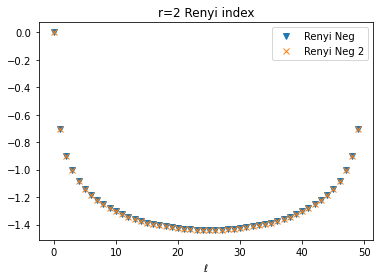

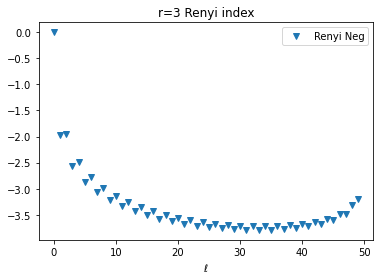

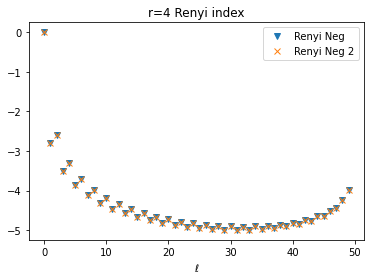

In [14]:
# print(8*np.log(2))
ent_plotter(r=2)
ent_plotter(r=3)
ent_plotter(r=4)

<ipython-input-15-8f879df0b7f2>:13: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Lsub_list),LN_ex,'s')
<ipython-input-15-8f879df0b7f2>:14: RuntimeWarning: divide by zero encountered in log
  xplot=np.log(np.tan(pi*Lsub_list/N))
<ipython-input-15-8f879df0b7f2>:15: RuntimeWarning: invalid value encountered in subtract
  yplot=(xplot-xplot[0])/4+ 0.47
<ipython-input-15-8f879df0b7f2>:16: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(Lsub_list),yplot,label='CFT')


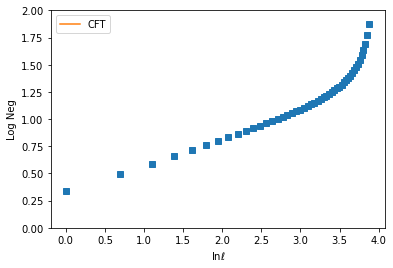

In [15]:
#plots log neg
LN_ex=np.zeros(len(Lsub_list)) # Log negativity

Gmat=np.dot(V1,np.matrix(V1).H)

for i_L in range(len(Lsub_list)):
    Lsub=Lsub_list[i_L]
    inds_A= np.arange(0,Lsub_list[i_L])
    inds_AB= np.arange(0,2*Lsub_list[i_L])
    LN_ex[i_L]= exact_log_neg_calc(Lsub,Lsub,Gmat[np.ix_(inds_AB,inds_AB)])
    
plt.figure()
plt.plot(np.log(Lsub_list),LN_ex,'s')
xplot=np.log(np.tan(pi*Lsub_list/N))
yplot=(xplot-xplot[0])/4+ 0.47
plt.plot(np.log(Lsub_list),yplot,label='CFT')
plt.legend()
plt.ylim([0,2])
plt.xlabel('$\ln \ell$')
plt.ylabel('Log Neg')
plt.show()